# Using a GAN to Generate Stress-strain Curves

## Problem Definition

Assuming bi-linear stress strain behavior of a material (characterized by $\sigma_y$, $E$, and $H$), generate sample stress-strain curves based on some initial samples of a stress-strain curve distrbution. 

<img src="bilinear.png" alt="Drawing" style="width: 300px;"/>

## Generating the training data

The training samples will be gathered by asuming independent, normal distributions for $\sigma_y$, $E$, and $H$.

  * $\sigma_y \sim \mathcal{N}(\mu=10, \sigma=0.5)$
  * $E \sim \mathcal{N}(\mu=1000, \sigma=50)$
  * $H \sim \mathcal{N}(\mu=50, \sigma=5)$

In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

Two helper functions

In [2]:
def get_stress(strains, E, s_y, H):
    e_y = s_y / E
    elastic_strains = strains.copy()
    elastic_strains[elastic_strains > e_y] = e_y
    plastic_strains = strains - elastic_strains
    stresses = elastic_strains*E + plastic_strains*H
    return stresses

In [3]:
def generate_samples(max_strain, n_strain, n_samples):
    strain = np.linspace(0, max_strain, n_strain + 1)[1:]
    stresses = np.empty((n_samples, n_strain))
    for i in tqdm(range(n_samples), desc='Generating samples'):
        E = np.random.normal(1000, 50)
        s_y = np.random.normal(10, 0.5)
        H = np.random.normal(50, 5)
        stresses[i] = get_stress(strain, E, s_y, H)
    return stresses, strain

Make training data:

  * rows in stress_mat correspond to the stresses in a single stress strain curve (i.e. 1 sample)
  * columns in stress_mat correspond to a single strain value

In [4]:
N_SAMPLES = 100000
MAX_STRAIN = 0.02
NUM_STRAINS = 10

stress_mat, strains = generate_samples(MAX_STRAIN, NUM_STRAINS, N_SAMPLES)

Generating samples: 100%|██████████| 100000/100000 [00:01<00:00, 96257.63it/s]


Visualize the training distribution

In [5]:
from ipywidgets import interact
import ipywidgets as widgets

def plot_hist(x):
    fig, (ax_left, ax_right) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]},
                                       figsize=(16, 7))
    
    sns.violinplot(data=pd.DataFrame(data=stress_mat, columns=np.round(strains, 3)), 
                   ax=ax_left)
    ax_left.set(xlabel='strain', ylabel='stress')
    
    itemindex = np.argmin(abs(strains-x))
    sns.distplot(stress_mat[:, itemindex], bins=20)
    ax_right.set(xlim=(np.min(stress_mat), np.max(stress_mat)),
                 xlabel='stresses at strain of %.3f' % strains[itemindex])
    
interact(plot_hist, x=(0.0, 0.02, 0.002))

interactive(children=(FloatSlider(value=0.01, description='x', max=0.02, step=0.002), Output()), _dom_classes=…

<function __main__.plot_hist(x)>

## Train a GAN to produce samples that match this distribution

In [6]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Settings

In [7]:
EPOCHS = 150
N_SAMPLES = 1024
BATCH_SIZE = 16
ITERATIONS = int(N_SAMPLES/BATCH_SIZE)
TRAIN_STEPS = 10
NOISE_DIM = 10

### 1. Preparing the dataset

In [8]:
def generate_stress_samples(n_samples, preprocessing):
    stresses, _ = generate_samples(MAX_STRAIN, NUM_STRAINS, n_samples)
    stresses = np.array(stresses)
    
    scaled_stresses, stress_scaler = preprocessing(stresses)
    
    return scaled_stresses, stress_scaler

In [9]:
def standardize(data):
    scaler = StandardScaler()
    scaler.fit(data)
    standardized_data = scaler.transform(data)
    
    return standardized_data, scaler

In [10]:
def normalize(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    standardized_data = scaler.transform(data)
    
    return normalized_data, scaler

In [11]:
dataset, scaler = generate_stress_samples(N_SAMPLES, standardize)
np.random.shuffle(dataset)

Generating samples: 100%|██████████| 1024/1024 [00:00<00:00, 32949.50it/s]


### 2. Create Models

* #### Generator

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(NOISE_DIM,)))
    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(10, use_bias=False))
    
    return model
    

In [13]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5120      
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262144    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

* #### Discriminator

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(10,)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(10))
    model.add(layers.Dense(1))
    
    return model

In [15]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

### 3. Define loss and optimizers

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.BinaryAccuracy()

* #### Discriminator loss

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

* #### Discriminator accuracy

In [18]:
def discriminator_accuracy(real_output, fake_output):
    #outputs = tf.concat([real_output, fake_output], axis=0)
    #accuracy.update_state(tf.ones_like(outputs), outputs)
    
    accuracy.update_state(tf.ones_like(real_output), real_output)
    accuracy.update_state(tf.zeros_like(fake_output), fake_output)

* #### Generator loss

In [19]:
def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

* #### Optimizers

In [20]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=1e-3)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=1e-3)

### 4. Training
* #### Save checkpoints

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

* #### Training Step

In [22]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch, noise):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_batch = generator(noise, training=True)
        
        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_batch, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    discriminator_accuracy(real_output, fake_output)
    
    return disc_loss, gen_loss

In [23]:
def train(epochs):
    losses_per_epoch = []
    
    for epoch in range(epochs):
        start = time.time()
        
        for i in tqdm(range(ITERATIONS)):
            iter_start = time.time()
            
            sample_batch = dataset[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
            noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
            
            for step in range(TRAIN_STEPS):
                disc_loss, gen_loss = train_step(sample_batch, noise)
                
            if (i + 1) % 1000 == 0:
                print('Time for iteration {} is {:.5f} sec'.format(i + 1, time.time() - iter_start))
                
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print('Time for epoch {} is {:.5f} sec'.format(epoch + 1, time.time() - start))
        print("Discriminator loss: {:.4f}\t Generator loss: {:.4f}\n".format(disc_loss.numpy(), gen_loss.numpy()))
        print('Discriminator accuracy: {}\n'.format(accuracy.result().numpy()))
        losses_per_epoch.append([disc_loss, gen_loss])
        
    return np.array(losses_per_epoch)

In [24]:
%%time
losses_per_epoch = train(EPOCHS)

  0%|          | 0/64 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0624 15:29:10.162692 140118961190720 deprecation.py:323] From /home/jcuevas7/anaconda3/envs/tf2-beta1/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
  5%|▍         | 3/64 [00:00<00:02, 28.80it/s]

Time for epoch 1 is 4.92450 sec
Discriminator loss: 1.0835	 Generator loss: 2.8024

Discriminator accuracy: 0.9231933355331421



  6%|▋         | 4/64 [00:00<00:01, 33.48it/s]

Time for epoch 2 is 1.90397 sec
Discriminator loss: 0.6402	 Generator loss: 3.1098

Discriminator accuracy: 0.878173828125



  6%|▋         | 4/64 [00:00<00:01, 33.91it/s]

Time for epoch 3 is 1.82154 sec
Discriminator loss: 1.0508	 Generator loss: 1.7274

Discriminator accuracy: 0.8571940064430237



  6%|▋         | 4/64 [00:00<00:01, 34.15it/s]

Time for epoch 4 is 1.84057 sec
Discriminator loss: 0.7947	 Generator loss: 2.0034

Discriminator accuracy: 0.837023913860321



  6%|▋         | 4/64 [00:00<00:01, 36.37it/s]

Time for epoch 5 is 1.86011 sec
Discriminator loss: 0.9528	 Generator loss: 3.1377

Discriminator accuracy: 0.8219238519668579



  6%|▋         | 4/64 [00:00<00:01, 35.92it/s]

Time for epoch 6 is 1.80869 sec
Discriminator loss: 0.9433	 Generator loss: 1.5807

Discriminator accuracy: 0.8095052242279053



  6%|▋         | 4/64 [00:00<00:01, 32.44it/s]

Time for epoch 7 is 1.80097 sec
Discriminator loss: 0.9249	 Generator loss: 1.3335

Discriminator accuracy: 0.7976771593093872



  6%|▋         | 4/64 [00:00<00:01, 32.81it/s]

Time for epoch 8 is 1.83095 sec
Discriminator loss: 1.0914	 Generator loss: 1.3189

Discriminator accuracy: 0.783251941204071



  6%|▋         | 4/64 [00:00<00:01, 35.14it/s]

Time for epoch 9 is 1.84889 sec
Discriminator loss: 0.9931	 Generator loss: 1.2788

Discriminator accuracy: 0.7685926556587219



  6%|▋         | 4/64 [00:00<00:01, 35.62it/s]

Time for epoch 10 is 1.83516 sec
Discriminator loss: 1.1111	 Generator loss: 0.9373

Discriminator accuracy: 0.7540917992591858



  6%|▋         | 4/64 [00:00<00:01, 35.79it/s]

Time for epoch 11 is 1.83052 sec
Discriminator loss: 1.1023	 Generator loss: 1.0234

Discriminator accuracy: 0.7406960129737854



  6%|▋         | 4/64 [00:00<00:01, 34.47it/s]

Time for epoch 12 is 1.82334 sec
Discriminator loss: 1.2117	 Generator loss: 0.9141

Discriminator accuracy: 0.7273030877113342



  6%|▋         | 4/64 [00:00<00:01, 33.81it/s]

Time for epoch 13 is 1.82853 sec
Discriminator loss: 1.0131	 Generator loss: 1.0384

Discriminator accuracy: 0.7157865166664124



  5%|▍         | 3/64 [00:00<00:02, 27.10it/s]

Time for epoch 14 is 1.89268 sec
Discriminator loss: 1.4585	 Generator loss: 0.7243

Discriminator accuracy: 0.7050676345825195



  6%|▋         | 4/64 [00:00<00:01, 32.68it/s]

Time for epoch 15 is 1.88580 sec
Discriminator loss: 1.2708	 Generator loss: 0.8270

Discriminator accuracy: 0.6954655051231384



  6%|▋         | 4/64 [00:00<00:01, 34.27it/s]

Time for epoch 16 is 1.91653 sec
Discriminator loss: 1.2608	 Generator loss: 0.8323

Discriminator accuracy: 0.6868346929550171



  6%|▋         | 4/64 [00:00<00:01, 35.63it/s]

Time for epoch 17 is 1.85214 sec
Discriminator loss: 1.4008	 Generator loss: 0.7046

Discriminator accuracy: 0.6787712574005127



  6%|▋         | 4/64 [00:00<00:01, 33.66it/s]

Time for epoch 18 is 1.90153 sec
Discriminator loss: 1.3639	 Generator loss: 0.7773

Discriminator accuracy: 0.6712971925735474



  6%|▋         | 4/64 [00:00<00:01, 32.56it/s]

Time for epoch 19 is 1.90324 sec
Discriminator loss: 1.3239	 Generator loss: 0.7814

Discriminator accuracy: 0.6648463010787964



  6%|▋         | 4/64 [00:00<00:01, 36.29it/s]

Time for epoch 20 is 1.98150 sec
Discriminator loss: 1.3613	 Generator loss: 0.6819

Discriminator accuracy: 0.6587841510772705



  6%|▋         | 4/64 [00:00<00:01, 34.68it/s]

Time for epoch 21 is 1.90188 sec
Discriminator loss: 1.3387	 Generator loss: 0.7041

Discriminator accuracy: 0.6533203125



  6%|▋         | 4/64 [00:00<00:01, 33.83it/s]

Time for epoch 22 is 1.93984 sec
Discriminator loss: 1.2669	 Generator loss: 0.8870

Discriminator accuracy: 0.6483709216117859



  6%|▋         | 4/64 [00:00<00:01, 35.28it/s]

Time for epoch 23 is 1.88426 sec
Discriminator loss: 1.2522	 Generator loss: 0.8964

Discriminator accuracy: 0.6436969041824341



  5%|▍         | 3/64 [00:00<00:02, 29.79it/s]

Time for epoch 24 is 1.85173 sec
Discriminator loss: 1.3148	 Generator loss: 0.7352

Discriminator accuracy: 0.6394897699356079



  6%|▋         | 4/64 [00:00<00:01, 31.34it/s]

Time for epoch 25 is 2.07269 sec
Discriminator loss: 1.3678	 Generator loss: 0.7624

Discriminator accuracy: 0.6354160308837891



  5%|▍         | 3/64 [00:00<00:02, 29.55it/s]

Time for epoch 26 is 1.83190 sec
Discriminator loss: 1.3512	 Generator loss: 0.7003

Discriminator accuracy: 0.6319185495376587



  6%|▋         | 4/64 [00:00<00:01, 33.25it/s]

Time for epoch 27 is 1.88353 sec
Discriminator loss: 1.3448	 Generator loss: 0.7107

Discriminator accuracy: 0.6284270286560059



  6%|▋         | 4/64 [00:00<00:01, 33.47it/s]

Time for epoch 28 is 1.91853 sec
Discriminator loss: 1.2737	 Generator loss: 0.7638

Discriminator accuracy: 0.6253592371940613



  6%|▋         | 4/64 [00:00<00:01, 35.05it/s]

Time for epoch 29 is 1.87044 sec
Discriminator loss: 1.2869	 Generator loss: 0.8023

Discriminator accuracy: 0.6224744319915771



  6%|▋         | 4/64 [00:00<00:01, 35.74it/s]

Time for epoch 30 is 1.86405 sec
Discriminator loss: 1.2454	 Generator loss: 0.8002

Discriminator accuracy: 0.6201269626617432



  6%|▋         | 4/64 [00:00<00:01, 32.27it/s]

Time for epoch 31 is 1.91380 sec
Discriminator loss: 1.3153	 Generator loss: 0.7448

Discriminator accuracy: 0.6178537607192993



  6%|▋         | 4/64 [00:00<00:01, 36.01it/s]

Time for epoch 32 is 1.86814 sec
Discriminator loss: 1.4343	 Generator loss: 0.7230

Discriminator accuracy: 0.6157684326171875



  6%|▋         | 4/64 [00:00<00:01, 33.35it/s]

Time for epoch 33 is 1.85070 sec
Discriminator loss: 1.3195	 Generator loss: 0.7804

Discriminator accuracy: 0.6138065457344055



  6%|▋         | 4/64 [00:00<00:01, 32.36it/s]

Time for epoch 34 is 1.81495 sec
Discriminator loss: 1.3122	 Generator loss: 0.7025

Discriminator accuracy: 0.6120203137397766



  6%|▋         | 4/64 [00:00<00:01, 35.52it/s]

Time for epoch 35 is 1.87141 sec
Discriminator loss: 1.3029	 Generator loss: 0.7204

Discriminator accuracy: 0.6101785898208618



  6%|▋         | 4/64 [00:00<00:01, 34.62it/s]

Time for epoch 36 is 1.84967 sec
Discriminator loss: 1.3151	 Generator loss: 0.7641

Discriminator accuracy: 0.6087076663970947



  6%|▋         | 4/64 [00:00<00:01, 35.26it/s]

Time for epoch 37 is 1.85707 sec
Discriminator loss: 1.3075	 Generator loss: 0.6982

Discriminator accuracy: 0.6072503328323364



  6%|▋         | 4/64 [00:00<00:01, 35.34it/s]

Time for epoch 38 is 1.84441 sec
Discriminator loss: 1.3561	 Generator loss: 0.7793

Discriminator accuracy: 0.6057758331298828



  6%|▋         | 4/64 [00:00<00:01, 34.88it/s]

Time for epoch 39 is 1.87028 sec
Discriminator loss: 1.3399	 Generator loss: 0.7556

Discriminator accuracy: 0.6044884324073792



  5%|▍         | 3/64 [00:00<00:02, 29.99it/s]

Time for epoch 40 is 1.88210 sec
Discriminator loss: 1.3312	 Generator loss: 0.7701

Discriminator accuracy: 0.6032605171203613



  6%|▋         | 4/64 [00:00<00:01, 32.25it/s]

Time for epoch 41 is 1.85724 sec
Discriminator loss: 1.2780	 Generator loss: 0.8499

Discriminator accuracy: 0.602046012878418



  6%|▋         | 4/64 [00:00<00:01, 34.86it/s]

Time for epoch 42 is 1.83635 sec
Discriminator loss: 1.3212	 Generator loss: 0.6876

Discriminator accuracy: 0.6009067893028259



  6%|▋         | 4/64 [00:00<00:01, 35.64it/s]

Time for epoch 43 is 1.82919 sec
Discriminator loss: 1.3645	 Generator loss: 0.6986

Discriminator accuracy: 0.5999284386634827



  6%|▋         | 4/64 [00:00<00:01, 35.82it/s]

Time for epoch 44 is 1.85361 sec
Discriminator loss: 1.3257	 Generator loss: 0.7020

Discriminator accuracy: 0.5989745855331421



  6%|▋         | 4/64 [00:00<00:01, 34.69it/s]

Time for epoch 45 is 1.85986 sec
Discriminator loss: 1.2638	 Generator loss: 0.8711

Discriminator accuracy: 0.5979937314987183



  6%|▋         | 4/64 [00:00<00:01, 33.75it/s]

Time for epoch 46 is 1.87334 sec
Discriminator loss: 1.3449	 Generator loss: 0.6840

Discriminator accuracy: 0.5971648097038269



  6%|▋         | 4/64 [00:00<00:01, 33.20it/s]

Time for epoch 47 is 1.85727 sec
Discriminator loss: 1.3644	 Generator loss: 0.7620

Discriminator accuracy: 0.5963981747627258



  6%|▋         | 4/64 [00:00<00:01, 31.34it/s]

Time for epoch 48 is 1.92336 sec
Discriminator loss: 1.2910	 Generator loss: 0.7972

Discriminator accuracy: 0.5957183837890625



  6%|▋         | 4/64 [00:00<00:01, 34.22it/s]

Time for epoch 49 is 1.90670 sec
Discriminator loss: 1.3379	 Generator loss: 0.7486

Discriminator accuracy: 0.5948570966720581



  6%|▋         | 4/64 [00:00<00:01, 31.68it/s]

Time for epoch 50 is 2.00207 sec
Discriminator loss: 1.3260	 Generator loss: 0.8270

Discriminator accuracy: 0.5942587852478027



  5%|▍         | 3/64 [00:00<00:02, 29.65it/s]

Time for epoch 51 is 1.99045 sec
Discriminator loss: 1.3480	 Generator loss: 0.7015

Discriminator accuracy: 0.5934838652610779



  6%|▋         | 4/64 [00:00<00:01, 34.97it/s]

Time for epoch 52 is 1.91659 sec
Discriminator loss: 1.2196	 Generator loss: 0.8855

Discriminator accuracy: 0.5928654670715332



  6%|▋         | 4/64 [00:00<00:01, 34.04it/s]

Time for epoch 53 is 1.90640 sec
Discriminator loss: 1.5442	 Generator loss: 0.7352

Discriminator accuracy: 0.5923837423324585



  6%|▋         | 4/64 [00:00<00:01, 35.70it/s]

Time for epoch 54 is 1.86154 sec
Discriminator loss: 1.1907	 Generator loss: 0.9520

Discriminator accuracy: 0.5917552709579468



  6%|▋         | 4/64 [00:00<00:01, 36.78it/s]

Time for epoch 55 is 1.82770 sec
Discriminator loss: 1.3161	 Generator loss: 0.7387

Discriminator accuracy: 0.5913751721382141



  6%|▋         | 4/64 [00:00<00:01, 35.57it/s]

Time for epoch 56 is 1.79812 sec
Discriminator loss: 1.2887	 Generator loss: 0.7876

Discriminator accuracy: 0.5908281803131104



  6%|▋         | 4/64 [00:00<00:01, 33.28it/s]

Time for epoch 57 is 1.80143 sec
Discriminator loss: 1.3169	 Generator loss: 0.7901

Discriminator accuracy: 0.5902429223060608



  6%|▋         | 4/64 [00:00<00:01, 36.57it/s]

Time for epoch 58 is 1.80434 sec
Discriminator loss: 1.2481	 Generator loss: 0.9239

Discriminator accuracy: 0.5898193120956421



  6%|▋         | 4/64 [00:00<00:01, 36.16it/s]

Time for epoch 59 is 1.80952 sec
Discriminator loss: 1.3407	 Generator loss: 0.7376

Discriminator accuracy: 0.589494526386261



  6%|▋         | 4/64 [00:00<00:01, 35.47it/s]

Time for epoch 60 is 1.83769 sec
Discriminator loss: 1.4599	 Generator loss: 0.8119

Discriminator accuracy: 0.5889974236488342



  6%|▋         | 4/64 [00:00<00:01, 36.00it/s]

Time for epoch 61 is 1.86136 sec
Discriminator loss: 1.2757	 Generator loss: 0.7481

Discriminator accuracy: 0.5887014865875244



  6%|▋         | 4/64 [00:00<00:01, 33.75it/s]

Time for epoch 62 is 1.80097 sec
Discriminator loss: 1.3994	 Generator loss: 0.7274

Discriminator accuracy: 0.5883316397666931



  6%|▋         | 4/64 [00:00<00:01, 34.06it/s]

Time for epoch 63 is 1.80232 sec
Discriminator loss: 1.3593	 Generator loss: 0.8624

Discriminator accuracy: 0.5879154205322266



  6%|▋         | 4/64 [00:00<00:01, 36.25it/s]

Time for epoch 64 is 1.80471 sec
Discriminator loss: 1.2118	 Generator loss: 0.8439

Discriminator accuracy: 0.5874916315078735



  6%|▋         | 4/64 [00:00<00:01, 36.65it/s]

Time for epoch 65 is 1.82733 sec
Discriminator loss: 1.3129	 Generator loss: 0.7734

Discriminator accuracy: 0.5872491002082825



  6%|▋         | 4/64 [00:00<00:01, 36.52it/s]

Time for epoch 66 is 1.80760 sec
Discriminator loss: 1.2168	 Generator loss: 0.9970

Discriminator accuracy: 0.5870183706283569



  6%|▋         | 4/64 [00:00<00:01, 34.57it/s]

Time for epoch 67 is 1.80236 sec
Discriminator loss: 1.3852	 Generator loss: 0.9795

Discriminator accuracy: 0.5867609977722168



  6%|▋         | 4/64 [00:00<00:01, 33.29it/s]

Time for epoch 68 is 1.79959 sec
Discriminator loss: 1.3015	 Generator loss: 0.8861

Discriminator accuracy: 0.5865018963813782



  6%|▋         | 4/64 [00:00<00:01, 36.37it/s]

Time for epoch 69 is 1.80826 sec
Discriminator loss: 1.2760	 Generator loss: 0.7882

Discriminator accuracy: 0.5862488746643066



  6%|▋         | 4/64 [00:00<00:01, 36.33it/s]

Time for epoch 70 is 1.82180 sec
Discriminator loss: 1.3379	 Generator loss: 0.8203

Discriminator accuracy: 0.5860205292701721



  6%|▋         | 4/64 [00:00<00:01, 35.46it/s]

Time for epoch 71 is 1.80740 sec
Discriminator loss: 1.1531	 Generator loss: 0.8974

Discriminator accuracy: 0.5859196186065674



  6%|▋         | 4/64 [00:00<00:01, 35.73it/s]

Time for epoch 72 is 1.81509 sec
Discriminator loss: 1.2987	 Generator loss: 0.8473

Discriminator accuracy: 0.5857204794883728



  5%|▍         | 3/64 [00:00<00:02, 28.38it/s]

Time for epoch 73 is 1.89024 sec
Discriminator loss: 1.3883	 Generator loss: 0.7387

Discriminator accuracy: 0.5855870246887207



  6%|▋         | 4/64 [00:00<00:01, 33.03it/s]

Time for epoch 74 is 1.99193 sec
Discriminator loss: 1.2521	 Generator loss: 0.7483

Discriminator accuracy: 0.585422158241272



  5%|▍         | 3/64 [00:00<00:02, 29.43it/s]

Time for epoch 75 is 1.83770 sec
Discriminator loss: 1.2228	 Generator loss: 0.7887

Discriminator accuracy: 0.5852734446525574



  6%|▋         | 4/64 [00:00<00:01, 35.40it/s]

Time for epoch 76 is 1.89482 sec
Discriminator loss: 1.2289	 Generator loss: 0.9024

Discriminator accuracy: 0.5850393176078796



  6%|▋         | 4/64 [00:00<00:01, 36.47it/s]

Time for epoch 77 is 1.80823 sec
Discriminator loss: 1.1868	 Generator loss: 1.0983

Discriminator accuracy: 0.5847744941711426



  6%|▋         | 4/64 [00:00<00:01, 33.27it/s]

Time for epoch 78 is 1.98167 sec
Discriminator loss: 1.1679	 Generator loss: 0.8540

Discriminator accuracy: 0.5846104025840759



  6%|▋         | 4/64 [00:00<00:01, 33.58it/s]

Time for epoch 79 is 1.88701 sec
Discriminator loss: 1.2556	 Generator loss: 0.7966

Discriminator accuracy: 0.5845468044281006



  6%|▋         | 4/64 [00:00<00:01, 33.84it/s]

Time for epoch 80 is 1.89681 sec
Discriminator loss: 1.1299	 Generator loss: 0.8692

Discriminator accuracy: 0.5844506621360779



  6%|▋         | 4/64 [00:00<00:01, 34.12it/s]

Time for epoch 81 is 1.88400 sec
Discriminator loss: 1.3402	 Generator loss: 0.7576

Discriminator accuracy: 0.5844226479530334



  6%|▋         | 4/64 [00:00<00:01, 35.15it/s]

Time for epoch 82 is 1.82840 sec
Discriminator loss: 1.2969	 Generator loss: 0.7886

Discriminator accuracy: 0.5842458009719849



  6%|▋         | 4/64 [00:00<00:01, 33.09it/s]

Time for epoch 83 is 1.78853 sec
Discriminator loss: 1.2933	 Generator loss: 0.8113

Discriminator accuracy: 0.5841520428657532



  6%|▋         | 4/64 [00:00<00:01, 36.26it/s]

Time for epoch 84 is 1.80584 sec
Discriminator loss: 1.1126	 Generator loss: 0.9942

Discriminator accuracy: 0.5839861035346985



  6%|▋         | 4/64 [00:00<00:01, 36.22it/s]

Time for epoch 85 is 1.82689 sec
Discriminator loss: 1.2804	 Generator loss: 0.8785

Discriminator accuracy: 0.5839866995811462



  6%|▋         | 4/64 [00:00<00:01, 36.31it/s]

Time for epoch 86 is 1.81105 sec
Discriminator loss: 1.1652	 Generator loss: 0.8872

Discriminator accuracy: 0.5840354561805725



  6%|▋         | 4/64 [00:00<00:01, 35.60it/s]

Time for epoch 87 is 1.81860 sec
Discriminator loss: 1.2942	 Generator loss: 0.8594

Discriminator accuracy: 0.5840449929237366



  6%|▋         | 4/64 [00:00<00:01, 33.85it/s]

Time for epoch 88 is 1.78901 sec
Discriminator loss: 1.2007	 Generator loss: 0.9225

Discriminator accuracy: 0.584063708782196



  6%|▋         | 4/64 [00:00<00:01, 36.37it/s]

Time for epoch 89 is 1.80290 sec
Discriminator loss: 1.3908	 Generator loss: 0.8062

Discriminator accuracy: 0.5840381383895874



  6%|▋         | 4/64 [00:00<00:01, 37.10it/s]

Time for epoch 90 is 1.83870 sec
Discriminator loss: 1.3728	 Generator loss: 0.8117

Discriminator accuracy: 0.5840027928352356



  6%|▋         | 4/64 [00:00<00:01, 36.07it/s]

Time for epoch 91 is 1.81140 sec
Discriminator loss: 1.2862	 Generator loss: 0.7737

Discriminator accuracy: 0.5840396285057068



  6%|▋         | 4/64 [00:00<00:01, 35.87it/s]

Time for epoch 92 is 1.81050 sec
Discriminator loss: 1.2746	 Generator loss: 0.8825

Discriminator accuracy: 0.5841367244720459



  6%|▋         | 4/64 [00:00<00:01, 32.89it/s]

Time for epoch 93 is 1.81622 sec
Discriminator loss: 1.1981	 Generator loss: 0.8248

Discriminator accuracy: 0.5842374563217163



  6%|▋         | 4/64 [00:00<00:01, 33.64it/s]

Time for epoch 94 is 1.81724 sec
Discriminator loss: 1.2755	 Generator loss: 0.8444

Discriminator accuracy: 0.5843245983123779



  6%|▋         | 4/64 [00:00<00:01, 34.71it/s]

Time for epoch 95 is 1.84529 sec
Discriminator loss: 1.3103	 Generator loss: 0.7690

Discriminator accuracy: 0.5843472480773926



  6%|▋         | 4/64 [00:00<00:01, 36.12it/s]

Time for epoch 96 is 1.95377 sec
Discriminator loss: 1.1935	 Generator loss: 0.9336

Discriminator accuracy: 0.584411084651947



  6%|▋         | 4/64 [00:00<00:01, 33.63it/s]

Time for epoch 97 is 1.85302 sec
Discriminator loss: 1.1468	 Generator loss: 1.0753

Discriminator accuracy: 0.5844922661781311



  6%|▋         | 4/64 [00:00<00:01, 31.06it/s]

Time for epoch 98 is 1.96651 sec
Discriminator loss: 1.2582	 Generator loss: 0.8949

Discriminator accuracy: 0.5845469236373901



  6%|▋         | 4/64 [00:00<00:01, 35.12it/s]

Time for epoch 99 is 1.93577 sec
Discriminator loss: 1.4164	 Generator loss: 0.7361

Discriminator accuracy: 0.5846457481384277



  6%|▋         | 4/64 [00:00<00:01, 36.18it/s]

Time for epoch 100 is 1.95176 sec
Discriminator loss: 1.1533	 Generator loss: 0.9947

Discriminator accuracy: 0.5846806764602661



  6%|▋         | 4/64 [00:00<00:01, 34.98it/s]

Time for epoch 101 is 1.88620 sec
Discriminator loss: 1.3135	 Generator loss: 0.8806

Discriminator accuracy: 0.584741473197937



  6%|▋         | 4/64 [00:00<00:01, 32.07it/s]

Time for epoch 102 is 1.84235 sec
Discriminator loss: 1.2570	 Generator loss: 1.1673

Discriminator accuracy: 0.5848541855812073



  6%|▋         | 4/64 [00:00<00:01, 33.22it/s]

Time for epoch 103 is 1.85745 sec
Discriminator loss: 1.2570	 Generator loss: 0.8680

Discriminator accuracy: 0.5849376916885376



  6%|▋         | 4/64 [00:00<00:01, 35.70it/s]

Time for epoch 104 is 1.82300 sec
Discriminator loss: 1.3547	 Generator loss: 0.7483

Discriminator accuracy: 0.5849895477294922



  6%|▋         | 4/64 [00:00<00:01, 36.34it/s]

Time for epoch 105 is 1.84946 sec
Discriminator loss: 1.2652	 Generator loss: 0.8222

Discriminator accuracy: 0.5850269794464111



  6%|▋         | 4/64 [00:00<00:01, 35.20it/s]

Time for epoch 106 is 1.83741 sec
Discriminator loss: 1.2314	 Generator loss: 0.8451

Discriminator accuracy: 0.5850857496261597



  6%|▋         | 4/64 [00:00<00:01, 34.42it/s]

Time for epoch 107 is 1.82314 sec
Discriminator loss: 1.2987	 Generator loss: 0.7600

Discriminator accuracy: 0.585213303565979



  6%|▋         | 4/64 [00:00<00:01, 34.53it/s]

Time for epoch 108 is 1.83791 sec
Discriminator loss: 1.1877	 Generator loss: 0.8762

Discriminator accuracy: 0.5853126645088196



  6%|▋         | 4/64 [00:00<00:01, 32.07it/s]

Time for epoch 109 is 1.81250 sec
Discriminator loss: 1.3370	 Generator loss: 0.8682

Discriminator accuracy: 0.5854985117912292



  6%|▋         | 4/64 [00:00<00:01, 35.38it/s]

Time for epoch 110 is 1.84380 sec
Discriminator loss: 1.1646	 Generator loss: 0.8468

Discriminator accuracy: 0.5855863690376282



  6%|▋         | 4/64 [00:00<00:01, 34.96it/s]

Time for epoch 111 is 1.83521 sec
Discriminator loss: 1.2076	 Generator loss: 0.8642

Discriminator accuracy: 0.5856519937515259



  6%|▋         | 4/64 [00:00<00:01, 36.02it/s]

Time for epoch 112 is 1.86790 sec
Discriminator loss: 1.3150	 Generator loss: 0.8094

Discriminator accuracy: 0.585803210735321



  6%|▋         | 4/64 [00:00<00:01, 35.82it/s]

Time for epoch 113 is 1.83528 sec
Discriminator loss: 1.2446	 Generator loss: 0.8442

Discriminator accuracy: 0.5859504342079163



  6%|▋         | 4/64 [00:00<00:01, 34.68it/s]

Time for epoch 114 is 1.85088 sec
Discriminator loss: 1.2783	 Generator loss: 0.8944

Discriminator accuracy: 0.5860719680786133



  6%|▋         | 4/64 [00:00<00:01, 32.66it/s]

Time for epoch 115 is 1.85165 sec
Discriminator loss: 1.1987	 Generator loss: 0.9193

Discriminator accuracy: 0.5862419605255127



  6%|▋         | 4/64 [00:00<00:01, 34.12it/s]

Time for epoch 116 is 1.82590 sec
Discriminator loss: 1.1806	 Generator loss: 0.9408

Discriminator accuracy: 0.5864295959472656



  6%|▋         | 4/64 [00:00<00:01, 35.13it/s]

Time for epoch 117 is 1.83146 sec
Discriminator loss: 1.1706	 Generator loss: 0.9816

Discriminator accuracy: 0.5865342617034912



  6%|▋         | 4/64 [00:00<00:01, 35.48it/s]

Time for epoch 118 is 1.84304 sec
Discriminator loss: 1.0965	 Generator loss: 1.0688

Discriminator accuracy: 0.5866628885269165



  6%|▋         | 4/64 [00:00<00:01, 34.05it/s]

Time for epoch 119 is 1.85702 sec
Discriminator loss: 1.2964	 Generator loss: 0.8535

Discriminator accuracy: 0.5867790579795837



  6%|▋         | 4/64 [00:00<00:01, 32.92it/s]

Time for epoch 120 is 1.89655 sec
Discriminator loss: 1.0149	 Generator loss: 1.1301

Discriminator accuracy: 0.5869242548942566



  6%|▋         | 4/64 [00:00<00:01, 35.99it/s]

Time for epoch 121 is 1.87757 sec
Discriminator loss: 1.3203	 Generator loss: 0.9092

Discriminator accuracy: 0.587032675743103



  6%|▋         | 4/64 [00:00<00:01, 31.78it/s]

Time for epoch 122 is 2.02738 sec
Discriminator loss: 1.2444	 Generator loss: 0.9235

Discriminator accuracy: 0.5872066020965576



  6%|▋         | 4/64 [00:00<00:01, 33.67it/s]

Time for epoch 123 is 1.95121 sec
Discriminator loss: 1.1702	 Generator loss: 0.9157

Discriminator accuracy: 0.5873705744743347



  6%|▋         | 4/64 [00:00<00:01, 31.29it/s]

Time for epoch 124 is 1.87330 sec
Discriminator loss: 1.1832	 Generator loss: 0.9296

Discriminator accuracy: 0.5875440835952759



  6%|▋         | 4/64 [00:00<00:01, 33.93it/s]

Time for epoch 125 is 1.86954 sec
Discriminator loss: 1.2059	 Generator loss: 0.7554

Discriminator accuracy: 0.5876847505569458



  6%|▋         | 4/64 [00:00<00:01, 32.48it/s]

Time for epoch 126 is 1.89959 sec
Discriminator loss: 1.2001	 Generator loss: 1.3001

Discriminator accuracy: 0.5878247618675232



  6%|▋         | 4/64 [00:00<00:01, 33.83it/s]

Time for epoch 127 is 1.96718 sec
Discriminator loss: 1.2497	 Generator loss: 0.9501

Discriminator accuracy: 0.5879490375518799



  6%|▋         | 4/64 [00:00<00:01, 36.05it/s]

Time for epoch 128 is 1.86557 sec
Discriminator loss: 1.1964	 Generator loss: 1.0926

Discriminator accuracy: 0.5880454778671265



  6%|▋         | 4/64 [00:00<00:01, 35.03it/s]

Time for epoch 129 is 1.86045 sec
Discriminator loss: 1.2538	 Generator loss: 1.0059

Discriminator accuracy: 0.5882286429405212



  6%|▋         | 4/64 [00:00<00:01, 37.21it/s]

Time for epoch 130 is 1.92258 sec
Discriminator loss: 1.3880	 Generator loss: 0.8649

Discriminator accuracy: 0.5883315801620483



  6%|▋         | 4/64 [00:00<00:01, 35.34it/s]

Time for epoch 131 is 1.86760 sec
Discriminator loss: 1.1917	 Generator loss: 1.0448

Discriminator accuracy: 0.5883952975273132



  6%|▋         | 4/64 [00:00<00:01, 32.94it/s]

Time for epoch 132 is 1.94496 sec
Discriminator loss: 0.9757	 Generator loss: 1.1459

Discriminator accuracy: 0.5885490775108337



  6%|▋         | 4/64 [00:00<00:01, 36.45it/s]

Time for epoch 133 is 1.93327 sec
Discriminator loss: 1.1930	 Generator loss: 1.0376

Discriminator accuracy: 0.5887291431427002



  6%|▋         | 4/64 [00:00<00:01, 33.36it/s]

Time for epoch 134 is 1.88455 sec
Discriminator loss: 1.4022	 Generator loss: 0.9924

Discriminator accuracy: 0.5888956189155579



  6%|▋         | 4/64 [00:00<00:01, 30.34it/s]

Time for epoch 135 is 1.90014 sec
Discriminator loss: 1.4619	 Generator loss: 0.8364

Discriminator accuracy: 0.5890509486198425



  6%|▋         | 4/64 [00:00<00:01, 34.99it/s]

Time for epoch 136 is 1.86999 sec
Discriminator loss: 1.1371	 Generator loss: 1.0312

Discriminator accuracy: 0.5892168879508972



  6%|▋         | 4/64 [00:00<00:01, 35.81it/s]

Time for epoch 137 is 1.88542 sec
Discriminator loss: 1.0813	 Generator loss: 1.2275

Discriminator accuracy: 0.5893882513046265



  6%|▋         | 4/64 [00:00<00:01, 33.82it/s]

Time for epoch 138 is 1.87289 sec
Discriminator loss: 1.0609	 Generator loss: 1.1567

Discriminator accuracy: 0.5895118713378906



  6%|▋         | 4/64 [00:00<00:01, 35.20it/s]

Time for epoch 139 is 1.88947 sec
Discriminator loss: 1.1478	 Generator loss: 1.3353

Discriminator accuracy: 0.5896642208099365



  6%|▋         | 4/64 [00:00<00:01, 32.68it/s]

Time for epoch 140 is 1.86598 sec
Discriminator loss: 1.1913	 Generator loss: 0.9518

Discriminator accuracy: 0.589881420135498



  6%|▋         | 4/64 [00:00<00:01, 35.00it/s]

Time for epoch 141 is 1.88107 sec
Discriminator loss: 1.1126	 Generator loss: 0.8108

Discriminator accuracy: 0.5900903344154358



  6%|▋         | 4/64 [00:00<00:01, 32.35it/s]

Time for epoch 142 is 1.85513 sec
Discriminator loss: 1.1739	 Generator loss: 0.9007

Discriminator accuracy: 0.5902776718139648



  6%|▋         | 4/64 [00:00<00:01, 33.23it/s]

Time for epoch 143 is 1.82866 sec
Discriminator loss: 1.0563	 Generator loss: 0.9185

Discriminator accuracy: 0.5904498100280762



  6%|▋         | 4/64 [00:00<00:01, 32.92it/s]

Time for epoch 144 is 1.86932 sec
Discriminator loss: 1.1600	 Generator loss: 1.1152

Discriminator accuracy: 0.5906215906143188



  6%|▋         | 4/64 [00:00<00:01, 35.00it/s]

Time for epoch 145 is 1.90168 sec
Discriminator loss: 1.1284	 Generator loss: 1.3019

Discriminator accuracy: 0.5907846093177795



  6%|▋         | 4/64 [00:00<00:01, 35.42it/s]

Time for epoch 146 is 1.88215 sec
Discriminator loss: 1.5101	 Generator loss: 0.7094

Discriminator accuracy: 0.5910005569458008



  6%|▋         | 4/64 [00:00<00:01, 35.87it/s]

Time for epoch 147 is 1.84758 sec
Discriminator loss: 1.3032	 Generator loss: 0.8406

Discriminator accuracy: 0.5911548137664795



  6%|▋         | 4/64 [00:00<00:01, 35.55it/s]

Time for epoch 148 is 1.83086 sec
Discriminator loss: 1.2618	 Generator loss: 1.3738

Discriminator accuracy: 0.5913240909576416



  6%|▋         | 4/64 [00:00<00:01, 33.43it/s]

Time for epoch 149 is 1.83902 sec
Discriminator loss: 1.2054	 Generator loss: 1.1441

Discriminator accuracy: 0.5915196537971497



100%|██████████| 64/64 [00:01<00:00, 35.84it/s]

Time for epoch 150 is 1.83993 sec
Discriminator loss: 1.0826	 Generator loss: 1.1587

Discriminator accuracy: 0.5917496681213379

CPU times: user 27min 58s, sys: 2min 39s, total: 30min 37s
Wall time: 4min 42s


### 5. Visualize Results

In [25]:
def plot_examples(real, generated):
    r_ax = plt.scatter(np.expand_dims(strains, -1), np.expand_dims(real, -1), label='Real Data')
    g_ax = plt.scatter(np.expand_dims(strains, -1), np.expand_dims(generated, -1), label='Generated Data')
    
    plt.legend()
    plt.title('Examples')
    plt.tight_layout()

In [26]:
def plot_hist_examples(x):
    fig, (ax_left, ax_right) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]},
                                       figsize=(16, 7))
    
    sns.violinplot(data=pd.DataFrame(data=unscaled_pred, columns=np.round(strains[0], 3)), 
                   ax=ax_left)
    ax_left.set(xlabel='strain', ylabel='stress')
    
    itemindex = np.argmin(abs(strains[0]-x))
    sns.distplot(unscaled_pred[:, itemindex], bins=20)
    ax_right.set(xlim=(np.min(unscaled_pred), np.max(unscaled_pred)),
                 xlabel='stresses at strain of %.3f' % strains[0, itemindex])

* #### Plotting data distribution

Generating samples: 100%|██████████| 100000/100000 [00:01<00:00, 82610.93it/s]


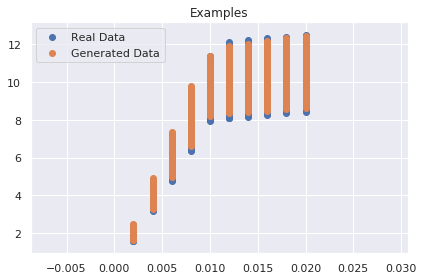

In [27]:
num_examples = 100000
seed = tf.random.normal([num_examples, NOISE_DIM])

pred = generator(seed, training=False)
unscaled_pred = scaler.inverse_transform(pred)

samples, strains = generate_samples(MAX_STRAIN, NUM_STRAINS, num_examples)
strains = strains * np.ones((num_examples, 1))

plot_examples(samples, unscaled_pred)

In [28]:
interact(plot_hist_examples, x=(0.0, 0.02, 0.002))

interactive(children=(FloatSlider(value=0.01, description='x', max=0.02, step=0.002), Output()), _dom_classes=…

<function __main__.plot_hist_examples(x)>

* #### Plotting the generator's and the discriminator's loss.

In [29]:
def plot_losses(losses):
    d_ax = plt.plot(losses[:,0], label='Discriminator loss')
    g_ax = plt.plot(losses[:,1], label='Generator loss')
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Network losses')
    plt.tight_layout()

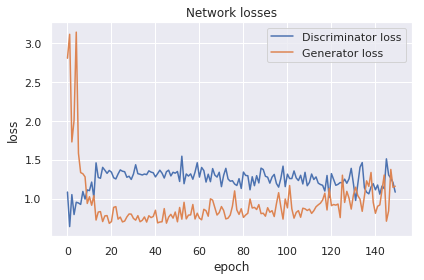

In [30]:
plot_losses(losses_per_epoch)

* #### Plotting individual samples

In [31]:
def plot_single_sample(sample, n):
    fig = plt.figure(n)
    stress_ax = plt.plot(strains[0], sample)
    
    plt.xlabel('strain')
    plt.ylabel('stress')
    plt.legend()
    plt.title('Stress-Strain Curve ' + str(i + 1))
    plt.tight_layout()

W0624 15:34:34.810586 140118961190720 legend.py:1289] No handles with labels found to put in legend.
W0624 15:34:34.855727 140118961190720 legend.py:1289] No handles with labels found to put in legend.
W0624 15:34:34.899116 140118961190720 legend.py:1289] No handles with labels found to put in legend.
W0624 15:34:34.941411 140118961190720 legend.py:1289] No handles with labels found to put in legend.
W0624 15:34:34.982745 140118961190720 legend.py:1289] No handles with labels found to put in legend.
W0624 15:34:35.024270 140118961190720 legend.py:1289] No handles with labels found to put in legend.
W0624 15:34:35.066658 140118961190720 legend.py:1289] No handles with labels found to put in legend.
W0624 15:34:35.112954 140118961190720 legend.py:1289] No handles with labels found to put in legend.
W0624 15:34:35.153442 140118961190720 legend.py:1289] No handles with labels found to put in legend.
W0624 15:34:35.194137 140118961190720 legend.py:1289] No handles with labels found to put i

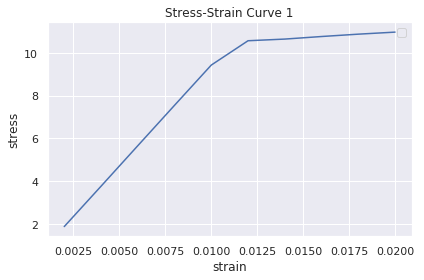

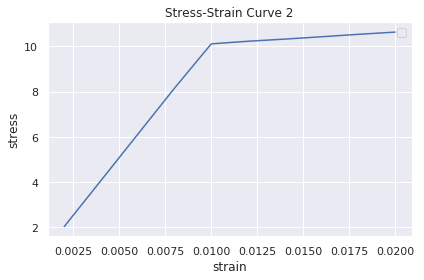

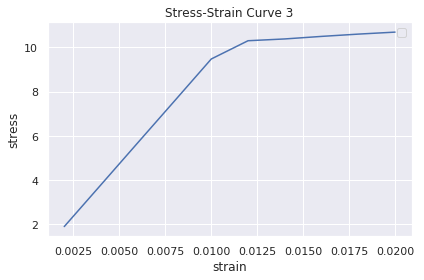

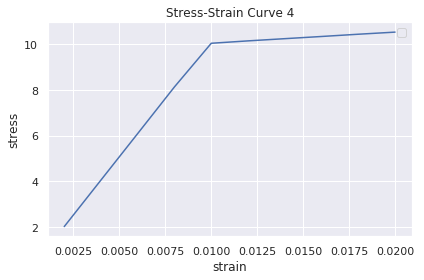

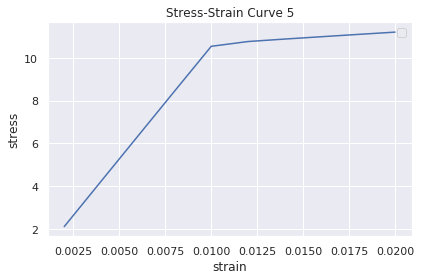

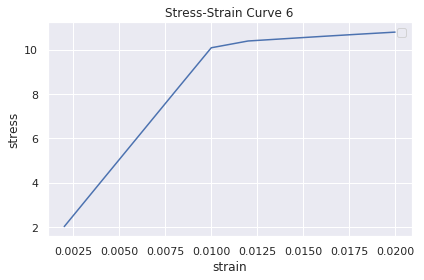

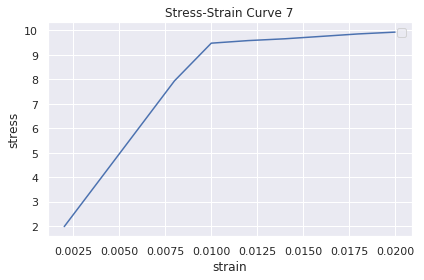

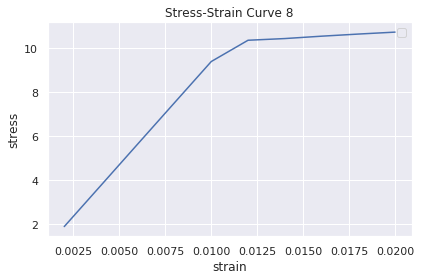

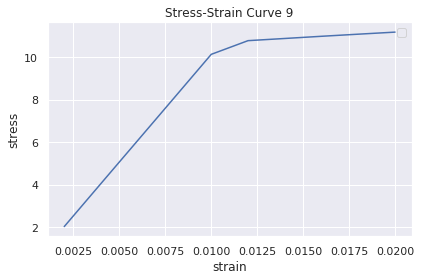

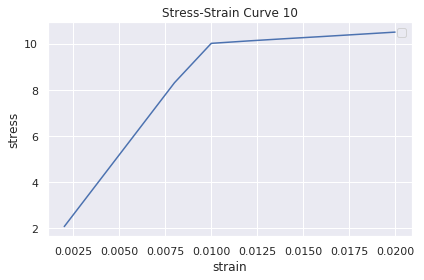

In [32]:
for i in range(10):
    plot_single_sample(unscaled_pred[i], i)